In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/coffee-bean-tanvir/Coffee Bean.csv
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (2).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (95).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (45).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (8).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (83).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (15).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (98).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (91).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (22).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (23).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (75).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (55).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (11).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (39).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (100).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (33).png
/kaggle/input/coffee-bean-tanvir/test/Da

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.svm import SVC

2025-08-27 18:22:23.008050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756318943.204198      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756318943.267003      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
base_dir = "/kaggle/input/coffee-bean-tanvir"

def create_dataframe(data_dir):
    file_paths = []
    labels = []
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)
    df = pd.DataFrame({"file_path": file_paths, "label": labels})
    return df.sample(frac=1).reset_index(drop=True)

train_df = create_dataframe(os.path.join(base_dir, "train"))
test_df = create_dataframe(os.path.join(base_dir, "test"))

print(train_df.head())
print(test_df.head())

                                           file_path   label
0  /kaggle/input/coffee-bean-tanvir/train/Medium/...  Medium
1  /kaggle/input/coffee-bean-tanvir/train/Green/g...   Green
2  /kaggle/input/coffee-bean-tanvir/train/Medium/...  Medium
3  /kaggle/input/coffee-bean-tanvir/train/Medium/...  Medium
4  /kaggle/input/coffee-bean-tanvir/train/Green/g...   Green
                                           file_path   label
0  /kaggle/input/coffee-bean-tanvir/test/Medium/m...  Medium
1  /kaggle/input/coffee-bean-tanvir/test/Green/gr...   Green
2  /kaggle/input/coffee-bean-tanvir/test/Light/li...   Light
3  /kaggle/input/coffee-bean-tanvir/test/Dark/dar...    Dark
4  /kaggle/input/coffee-bean-tanvir/test/Green/gr...   Green


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='file_path',
    y_col='label',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='file_path',
    y_col='label',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)

Found 1200 validated image filenames belonging to 4 classes.
Found 400 validated image filenames belonging to 4 classes.
Number of classes: 4


In [5]:
from tensorflow.keras.layers import Layer

class SelfAttention(Layer):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels

    def build(self, input_shape):
        self.f_conv = layers.Conv2D(self.channels//8, 1, padding='same')
        self.g_conv = layers.Conv2D(self.channels//8, 1, padding='same')
        self.h_conv = layers.Conv2D(self.channels, 1, padding='same')
        super(SelfAttention, self).build(input_shape)

    def call(self, x):
        f = self.f_conv(x)
        g = self.g_conv(x)
        h = self.h_conv(x)

        f_flat = tf.reshape(f, [tf.shape(x)[0], -1, self.channels//8])
        g_flat = tf.reshape(g, [tf.shape(x)[0], -1, self.channels//8])
        h_flat = tf.reshape(h, [tf.shape(x)[0], -1, self.channels])

        s = tf.matmul(g_flat, f_flat, transpose_b=True)
        beta = tf.nn.softmax(s, axis=-1)
        o = tf.matmul(beta, h_flat)
        o = tf.reshape(o, tf.shape(x))  # reshape to original input shape
        out = x + o
        return out

In [6]:
def build_attention_cnn(input_shape=(128,128,3), num_classes=4):
    inputs = Input(shape=input_shape)
    
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = SelfAttention(32)(x)
    
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = SelfAttention(64)(x)
    
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = SelfAttention(128)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

model = build_attention_cnn(num_classes=num_classes)
model.summary()

I0000 00:00:1756318956.924495      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention (SelfAttention)  │ (None, 64, 64, 32)     │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention_1                │ (None, 32, 32, 64)     │         5,200 │
│ (SelfAttention)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention_2                │ (None, 16, 16, 128)    │        20,640 │
│ (SelfAttention)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,510,300 (32.46 MB)

 Trainable params: 8,510,300 (32.46 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 20

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1756318965.488813      57 service.cc:148] XLA service 0x7a5d08017eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756318965.489510      57 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756318966.100748      57 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756318973.245890      57 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 ━━━━━━━━━━━━━━━━━━━━ 34s 536ms/step - accuracy: 0.2807 - loss: 2.3939 - val_accuracy: 0.5575 - val_loss: 0.8373
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - accuracy: 0.5301 - loss: 0.9157 - val_accuracy: 0.4050 - val_loss: 1.0440
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - accuracy: 0.5437 - loss: 0.9895 - val_accuracy: 0.7625 - val_loss: 0.4961
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.7110 - loss: 0.6353 - val_accuracy: 0.8125 - val_loss: 0.4086
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - accuracy: 0.7533 - loss: 0.5746 - val_accuracy: 0.9400 - val_loss: 0.1809
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - accuracy: 0.8777 - loss: 0.2892 - val_accuracy: 0.9475 - val_loss: 0.1471
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.9027 - loss: 0.2415 - val_accuracy: 0.9450 - val_loss: 0.1667
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.9149 - loss: 0.2550 - val_accuracy: 0.9700 - val

In [8]:
def extract_features(model, generator):
    feature_extractor = models.Model(inputs=model.input, outputs=model.layers[-3].output)
    features = []
    labels = []

    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        feat = feature_extractor.predict(x_batch)
        features.append(feat)
        labels.append(np.argmax(y_batch, axis=1))

    features = np.vstack(features)
    labels = np.hstack(labels)
    return features, labels

X_train_feat, y_train_labels = extract_features(model, train_generator)
X_test_feat, y_test_labels = extract_features(model, test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━

In [9]:
# Initialize and train an SVC
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_test_scaled = scaler.transform(X_test_feat)

In [10]:
from sklearn.svm import SVC

# Initialize and train an SVC
svm_model = SVC(probability=True, random_state=42) # probability=True is needed for roc_auc_score
svm_model.fit(X_train_scaled, y_train_labels)

SVC(probability=True, random_state=42)

Accuracy: 0.9325
Precision: 0.9364067966016991
Recall: 0.9324999999999999
F1-score: 0.9323214130595772
Confusion Matrix:
 [[95  0  0  5]
 [ 0 99  0  1]
 [ 0  0 99  1]
 [20  0  0 80]]


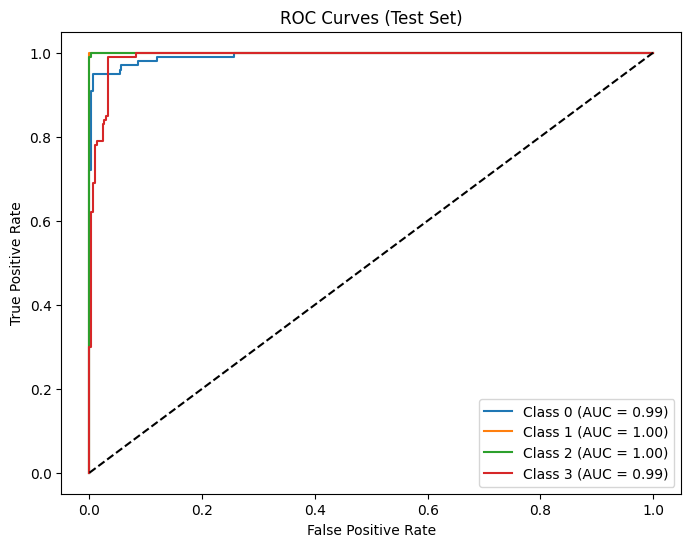

Test AUC: 0.9959416666666666


In [11]:
# ---- Predictions ----
y_test_pred = svm_model.predict(X_test_scaled)
y_test_proba = svm_model.predict_proba(X_test_scaled)

# ---- Basic Metrics ----
print("Accuracy:", accuracy_score(y_test_labels, y_test_pred))
print("Precision:", precision_score(y_test_labels, y_test_pred, average='macro'))
print("Recall:", recall_score(y_test_labels, y_test_pred, average='macro'))
print("F1-score:", f1_score(y_test_labels, y_test_pred, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_test_labels, y_test_pred))

# ---- ROC-AUC Curves ----
# Binarize labels for multi-class ROC
classes_present = np.unique(y_test_labels)
y_test_bin = label_binarize(y_test_labels, classes=classes_present)

# Only plot ROC if at least 2 classes are present
if y_test_bin.shape[1] > 1:
    plt.figure(figsize=(8,6))
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
        plt.plot(fpr, tpr, label=f"Class {classes_present[i]} (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Test Set)")
    plt.legend()
    plt.show()

    # Compute overall ROC-AUC
    print("Test AUC:", roc_auc_score(y_test_bin, y_test_proba, multi_class='ovr'))
else:
    print("ROC-AUC skipped: less than 2 classes present in test set")